In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *


# Extracting the point collection and the descriptors

In [3]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
with open('point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
with open('descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)
    
base_results_path = 'testing_results'
results_path = os.path.join(base_results_path,'nn_matcher')

if not os.path.exists(base_results_path): os.mkdir(base_results_path)
if not os.path.exists(results_path): os.mkdir(results_path)

partial_results_path = os.path.join(results_path,"partial")
successive_results_path = os.path.join(results_path,"successive")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
if not os.path.exists(successive_results_path): os.mkdir(successive_results_path)
    
results_path, partial_results_path, successive_results_path

('testing_results/nn_matcher',
 'testing_results/nn_matcher/partial',
 'testing_results/nn_matcher/successive')

In [4]:
# We'll use only a 300 samples for this.
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
#sample_points_300 = np.random.choice(1000,300,False)
    
with open('sample_arcore_points.pickle','rb') as f:
    sample_arcore_points = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    #print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue

# Step 1.1: HoloLens Raw spaces (validation)

In [8]:
descriptors = descriptors

for radius in np.arange(0.5,5.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    
    print("radius =",radius)
    
    for obj_, object_name, original_vertex in sample_points:
        
        t3 = time.time()
        
        #obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new=True,
                old = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
        
        t4 = time.time()

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
                 
            with bz2.BZ2File(partial_results_path+'/raw_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))

radius = 0.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.5 : Done with 2, in 0.574 seconds. Error rate 0.500


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.5 : Done with 68, in 20.373 seconds. Error rate 0.809


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 134, in 21.464 seconds. Error rate 0.843


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 200, in 20.984 seconds. Error rate 0.835


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 266, in 20.851 seconds. Error rate 0.816


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 332, in 21.338 seconds. Error rate 0.828


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 398, in 21.687 seconds. Error rate 0.832


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 464, in 20.994 seconds. Error rate 0.825


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 530, in 20.956 seconds. Error rate 0.832


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 596, in 21.573 seconds. Error rate 0.827


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 662, in 21.103 seconds. Error rate 0.826


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 728, in 19.960 seconds. Error rate 0.823


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 794, in 19.969 seconds. Error rate 0.825


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 860, in 19.946 seconds. Error rate 0.828


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 926, in 19.843 seconds. Error rate 0.830


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.5 : Done with 992, in 20.139 seconds. Error rate 0.836
0.5  Total Time to match 338.961 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 2, in 0.828 seconds. Error rate 0.500


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 68, in 40.275 seconds. Error rate 0.279


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 134, in 39.401 seconds. Error rate 0.254


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 200, in 38.573 seconds. Error rate 0.250


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 266, in 38.096 seconds. Error rate 0.248


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 332, in 37.852 seconds. Error rate 0.244


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 398, in 42.092 seconds. Error rate 0.266


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 464, in 41.180 seconds. Error rate 0.280


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 530, in 41.042 seconds. Error rate 0.274


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 596, in 41.688 seconds. Error rate 0.279


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 662, in 39.301 seconds. Error rate 0.278


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 728, in 37.002 seconds. Error rate 0.276


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 794, in 39.082 seconds. Error rate 0.277


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 860, in 38.620 seconds. Error rate 0.274


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 926, in 36.745 seconds. Error rate 0.274


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 992, in 40.726 seconds. Error rate 0.275
1.0  Total Time to match 685.070 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 2, in 1.603 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 68, in 82.769 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 134, in 77.487 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 200, in 75.363 seconds. Error rate 0.005


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 266, in 77.240 seconds. Error rate 0.008


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 332, in 76.240 seconds. Error rate 0.009


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 398, in 87.856 seconds. Error rate 0.010


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 464, in 82.508 seconds. Error rate 0.013


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 530, in 87.553 seconds. Error rate 0.011


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 596, in 84.765 seconds. Error rate 0.013


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 662, in 81.674 seconds. Error rate 0.012


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 728, in 73.797 seconds. Error rate 0.011


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: divide by zero encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv

   1.5 : Done with 794, in 81.515 seconds. Error rate 0.010


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: divide by zero encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv

   1.5 : Done with 860, in 77.500 seconds. Error rate 0.010


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: divide by zero encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv

   1.5 : Done with 926, in 76.779 seconds. Error rate 0.010


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: divide by zero encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv

   1.5 : Done with 992, in 86.417 seconds. Error rate 0.010
1.5  Total Time to match 1410.476 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 2, in 3.418 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 68, in 149.865 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 134, in 142.298 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 200, in 134.962 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 266, in 137.180 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 332, in 140.880 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 398, in 156.345 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 464, in 150.608 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 530, in 167.026 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 596, in 159.447 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 662, in 158.287 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 728, in 140.133 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.0 : Done with 794, in 158.849 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.0 : Done with 860, in 145.275 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.0 : Done with 926, in 148.294 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.0 : Done with 992, in 161.844 seconds. Error rate 0.000
2.0  Total Time to match 2596.322 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 2, in 5.353 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 68, in 242.824 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 134, in 232.314 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 200, in 223.121 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 266, in 233.683 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 332, in 231.080 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 398, in 260.974 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 464, in 250.357 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 530, in 283.580 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 596, in 263.144 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 662, in 305.566 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 728, in 280.870 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.5 : Done with 794, in 312.563 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.5 : Done with 860, in 299.833 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.5 : Done with 926, in 282.265 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.5 : Done with 992, in 276.536 seconds. Error rate 0.000
2.5  Total Time to match 4563.286 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 2, in 7.318 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 68, in 351.282 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 134, in 332.397 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 200, in 344.042 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 266, in 354.723 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 332, in 358.191 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 398, in 415.117 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 464, in 374.814 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 530, in 413.567 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 596, in 386.812 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 662, in 397.595 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 728, in 374.588 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.0 : Done with 794, in 425.346 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.0 : Done with 860, in 407.741 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.0 : Done with 926, in 410.537 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.0 : Done with 992, in 406.125 seconds. Error rate 0.000
3.0  Total Time to match 6458.775 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 2, in 8.801 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 68, in 480.259 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 134, in 448.588 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 200, in 452.614 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 266, in 471.946 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 332, in 498.153 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 398, in 534.307 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 464, in 489.489 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 530, in 542.447 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 596, in 529.709 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 662, in 547.943 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 728, in 494.450 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.5 : Done with 794, in 565.605 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.5 : Done with 860, in 544.339 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.5 : Done with 926, in 555.509 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   3.5 : Done with 992, in 552.764 seconds. Error rate 0.000
3.5  Total Time to match 8586.161 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 2, in 10.436 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 68, in 596.917 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 134, in 563.348 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 200, in 538.667 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 266, in 564.776 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 332, in 621.270 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 398, in 651.038 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 464, in 625.523 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 530, in 666.942 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 596, in 609.834 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 662, in 670.708 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 728, in 606.506 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.0 : Done with 794, in 709.111 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.0 : Done with 860, in 662.883 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.0 : Done with 926, in 682.519 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.0 : Done with 992, in 705.766 seconds. Error rate 0.000
4.0  Total Time to match 10504.076 seconds.
radius = 4.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 2, in 12.024 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 68, in 681.661 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 134, in 658.098 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 200, in 616.810 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 266, in 662.727 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 332, in 726.302 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 398, in 753.924 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 464, in 734.943 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 530, in 764.048 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 596, in 720.702 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 662, in 771.975 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 728, in 692.043 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.5 : Done with 794, in 794.979 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.5 : Done with 860, in 773.825 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.5 : Done with 926, in 809.297 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   4.5 : Done with 992, in 812.215 seconds. Error rate 0.000
4.5  Total Time to match 12122.845 seconds.
radius = 5.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 2, in 15.290 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 68, in 728.172 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 134, in 726.050 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 200, in 684.447 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 266, in 726.866 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 332, in 799.271 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 398, in 812.421 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 464, in 805.805 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 530, in 834.431 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 596, in 793.032 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 662, in 824.697 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 728, in 784.636 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   5.0 : Done with 794, in 885.495 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   5.0 : Done with 860, in 866.175 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   5.0 : Done with 926, in 902.701 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   5.0 : Done with 992, in 910.115 seconds. Error rate 0.000
5.0  Total Time to match 13319.854 seconds.


# Step 1.2: RANSAC-generalized HoloLens spaces evaluation

In [9]:
descriptors = descriptors

for radius in np.arange(0.5,5.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    
    print("radius =",radius)
    
    for obj_, object_name, original_vertex in sample_points: #[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new=True,
                old = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print(radius,"Error Rate:",)
            
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))

            t1  = time.time()
                        
            with bz2.BZ2File(partial_results_path+'/ransac_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
    with bz2.BZ2File(partial_results_path+'/ransac_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
        pickle.dump(partial_scores_pool, bz2_f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

radius = 0.5
0.5 Error Rate:
   0.5 : Done with 2, in 0.666 seconds. Error rate 1.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 Error Rate:
   0.5 : Done with 68, in 21.330 seconds. Error rate 0.941


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 134, in 20.829 seconds. Error rate 0.888


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 200, in 21.221 seconds. Error rate 0.850


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 266, in 21.347 seconds. Error rate 0.850


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 332, in 21.523 seconds. Error rate 0.849


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 398, in 22.111 seconds. Error rate 0.849


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 464, in 21.992 seconds. Error rate 0.851


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 530, in 22.789 seconds. Error rate 0.851


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 596, in 22.499 seconds. Error rate 0.856


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 662, in 22.356 seconds. Error rate 0.860


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 728, in 22.133 seconds. Error rate 0.857


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 794, in 22.818 seconds. Error rate 0.853


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 860, in 23.068 seconds. Error rate 0.853


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 926, in 23.037 seconds. Error rate 0.855


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 992, in 24.091 seconds. Error rate 0.851
0.5  Total Time to match 340.666 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 2, in 0.936 seconds. Error rate 0.500


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 68, in 41.395 seconds. Error rate 0.647


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 134, in 40.721 seconds. Error rate 0.657


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 200, in 39.657 seconds. Error rate 0.670


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 266, in 40.950 seconds. Error rate 0.662


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 332, in 41.576 seconds. Error rate 0.657


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 398, in 44.688 seconds. Error rate 0.653


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 464, in 44.016 seconds. Error rate 0.651


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 530, in 47.503 seconds. Error rate 0.640


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 596, in 46.241 seconds. Error rate 0.644


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 662, in 47.434 seconds. Error rate 0.642


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 728, in 44.816 seconds. Error rate 0.637


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 794, in 46.607 seconds. Error rate 0.637


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 860, in 48.399 seconds. Error rate 0.628


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 926, in 47.139 seconds. Error rate 0.629


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 992, in 51.229 seconds. Error rate 0.627
1.0  Total Time to match 698.467 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 2, in 1.740 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 68, in 81.863 seconds. Error rate 0.412


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 134, in 77.673 seconds. Error rate 0.388


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 200, in 80.350 seconds. Error rate 0.360


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 266, in 79.853 seconds. Error rate 0.357


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 332, in 81.407 seconds. Error rate 0.343


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 398, in 95.703 seconds. Error rate 0.332


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 464, in 91.269 seconds. Error rate 0.338


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 530, in 95.553 seconds. Error rate 0.343


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 596, in 96.290 seconds. Error rate 0.342


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 662, in 96.903 seconds. Error rate 0.335


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 728, in 90.393 seconds. Error rate 0.330


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 794, in 96.660 seconds. Error rate 0.315


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 860, in 94.044 seconds. Error rate 0.320


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 926, in 92.196 seconds. Error rate 0.332


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 992, in 103.712 seconds. Error rate 0.334
1.5  Total Time to match 1408.350 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 2, in 3.498 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 68, in 141.672 seconds. Error rate 0.221


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 134, in 142.881 seconds. Error rate 0.209


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 200, in 139.375 seconds. Error rate 0.215


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 266, in 141.578 seconds. Error rate 0.192


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 332, in 145.538 seconds. Error rate 0.196


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 398, in 167.915 seconds. Error rate 0.191


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 464, in 160.709 seconds. Error rate 0.190


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 530, in 177.679 seconds. Error rate 0.183


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 596, in 177.651 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 662, in 180.138 seconds. Error rate 0.186


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 728, in 162.993 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 794, in 181.146 seconds. Error rate 0.180


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 860, in 172.936 seconds. Error rate 0.183


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 926, in 173.438 seconds. Error rate 0.187


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 992, in 190.911 seconds. Error rate 0.185
2.0  Total Time to match 2552.178 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 2, in 5.346 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 68, in 236.130 seconds. Error rate 0.206


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 134, in 229.970 seconds. Error rate 0.187


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 200, in 221.803 seconds. Error rate 0.170


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 266, in 236.125 seconds. Error rate 0.154


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 332, in 235.985 seconds. Error rate 0.157


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 398, in 267.603 seconds. Error rate 0.148


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 464, in 266.706 seconds. Error rate 0.144


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 530, in 298.280 seconds. Error rate 0.136


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 596, in 287.942 seconds. Error rate 0.134


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 662, in 293.221 seconds. Error rate 0.133


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 728, in 269.699 seconds. Error rate 0.130


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 794, in 302.935 seconds. Error rate 0.123


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 860, in 295.089 seconds. Error rate 0.121


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 926, in 302.889 seconds. Error rate 0.127


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 992, in 315.662 seconds. Error rate 0.129
2.5  Total Time to match 4206.049 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 2, in 7.400 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 68, in 343.313 seconds. Error rate 0.118


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 134, in 337.608 seconds. Error rate 0.112


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 200, in 340.138 seconds. Error rate 0.110


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 266, in 359.197 seconds. Error rate 0.098


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 332, in 380.606 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 398, in 483.879 seconds. Error rate 0.101


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 464, in 449.420 seconds. Error rate 0.101


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 530, in 496.616 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 596, in 421.354 seconds. Error rate 0.102


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 662, in 438.558 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 728, in 407.007 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 794, in 451.632 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 860, in 441.112 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 926, in 454.538 seconds. Error rate 0.098


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 992, in 457.486 seconds. Error rate 0.099
3.0  Total Time to match 6460.929 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 2, in 7.989 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 68, in 466.284 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 134, in 434.406 seconds. Error rate 0.104


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 200, in 449.930 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 266, in 475.856 seconds. Error rate 0.068


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 332, in 509.021 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 398, in 561.559 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 464, in 513.930 seconds. Error rate 0.080


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 530, in 575.751 seconds. Error rate 0.079


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 596, in 558.232 seconds. Error rate 0.084


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 662, in 582.237 seconds. Error rate 0.083


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 728, in 532.270 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 794, in 608.979 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 860, in 593.087 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 926, in 613.406 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 992, in 604.391 seconds. Error rate 0.077
3.5  Total Time to match 8330.484 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 2, in 10.081 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 68, in 578.125 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 134, in 556.558 seconds. Error rate 0.060


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 200, in 547.347 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 266, in 567.160 seconds. Error rate 0.071


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 332, in 621.556 seconds. Error rate 0.066


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 398, in 674.441 seconds. Error rate 0.070


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 464, in 640.660 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 530, in 689.364 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 596, in 656.670 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 662, in 706.713 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 728, in 647.880 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 794, in 733.216 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 860, in 709.232 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 926, in 728.792 seconds. Error rate 0.079


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 992, in 740.543 seconds. Error rate 0.082
4.0  Total Time to match 10093.982 seconds.
radius = 4.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 2, in 12.216 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 68, in 678.452 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 134, in 653.481 seconds. Error rate 0.067


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 200, in 617.889 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 266, in 656.517 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 332, in 723.285 seconds. Error rate 0.081


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 398, in 767.983 seconds. Error rate 0.083


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 464, in 751.595 seconds. Error rate 0.082


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 530, in 801.826 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 596, in 760.417 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 662, in 824.948 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 728, in 745.036 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 794, in 851.309 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 860, in 817.723 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 926, in 869.301 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 992, in 859.948 seconds. Error rate 0.078
4.5  Total Time to match 11726.457 seconds.
radius = 5.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 2, in 14.782 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 68, in 715.862 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 134, in 732.443 seconds. Error rate 0.112


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 200, in 686.804 seconds. Error rate 0.105


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 266, in 736.149 seconds. Error rate 0.102


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 332, in 814.508 seconds. Error rate 0.108


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 398, in 841.780 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 464, in 859.260 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 530, in 865.050 seconds. Error rate 0.096


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 596, in 847.439 seconds. Error rate 0.096


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 662, in 889.947 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 728, in 837.874 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 794, in 950.987 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 860, in 903.738 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 926, in 958.625 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 992, in 944.673 seconds. Error rate 0.100
5.0  Total Time to match 12961.571 seconds.


# Step 1.3: ARCore spaces evaluation

In [10]:
descriptors = arcore_descriptors[:-1]
    
exp_eval_propeties = []

for radius in np.arange(0.5,5.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for obj_, obj_sample, object_name, original_vertex in sample_arcore_points:
    #for s_i in sample_points_300:
        
        t3 = time.time()
        
        #obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, ransac_pointCloud, tri_, u_n_ = arcore_spaces[obj_][obj_sample]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new=True,
                old=True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, descriptors)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                        
            with bz2.BZ2File(partial_results_path+'/arcore_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()
            
    with bz2.BZ2File(partial_results_path+'/arcore_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
        pickle.dump(partial_scores_pool, bz2_f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.5
   0.5 : Done with 2, in 0.252 seconds. Error rate 1.000
   (24, 7) (24, 7, 2) (24, 7, 2) in 0.110 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.5 : Done with 68, in 3.951 seconds. Error rate 0.868
   (20, 7) (20, 7, 2) (20, 7, 2) in 0.055 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 134, in 4.065 seconds. Error rate 0.851
   (28, 7) (28, 7, 2) (28, 7, 2) in 0.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 200, in 4.154 seconds. Error rate 0.855
   (36, 7) (36, 7, 2) (36, 7, 2) in 0.079 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 266, in 4.069 seconds. Error rate 0.846
   (28, 7) (28, 7, 2) (28, 7, 2) in 0.056 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 332, in 4.039 seconds. Error rate 0.858
   (28, 7) (28, 7, 2) (28, 7, 2) in 0.053 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 398, in 4.107 seconds. Error rate 0.852
   (34, 7) (34, 7, 2) (34, 7, 2) in 0.059 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 464, in 4.189 seconds. Error rate 0.847
   (30, 7) (30, 7, 2) (30, 7, 2) in 0.060 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 530, in 4.298 seconds. Error rate 0.845
   (24, 7) (24, 7, 2) (24, 7, 2) in 0.066 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 596, in 4.306 seconds. Error rate 0.844
   (29, 7) (29, 7, 2) (29, 7, 2) in 0.051 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 662, in 4.071 seconds. Error rate 0.843
   (26, 7) (26, 7, 2) (26, 7, 2) in 0.051 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 728, in 4.158 seconds. Error rate 0.839
   (20, 7) (20, 7, 2) (20, 7, 2) in 0.054 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 794, in 4.158 seconds. Error rate 0.831
   (29, 7) (29, 7, 2) (29, 7, 2) in 0.071 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 860, in 4.312 seconds. Error rate 0.824
   (19, 7) (19, 7, 2) (19, 7, 2) in 0.041 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 926, in 4.509 seconds. Error rate 0.825
   (36, 7) (36, 7, 2) (36, 7, 2) in 0.076 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


   0.5 : Done with 992, in 4.434 seconds. Error rate 0.825
   (31, 7) (31, 7, 2) (31, 7, 2) in 0.058 seconds
0.5  Total Time to match 81.841 seconds.
radius = 1.0
   1.0 : Done with 2, in 0.262 seconds. Error rate 1.000
   (81, 7) (81, 7, 2) (81, 7, 2) in 0.120 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 68, in 9.440 seconds. Error rate 0.824
   (75, 7) (75, 7, 2) (75, 7, 2) in 0.110 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 134, in 10.203 seconds. Error rate 0.843
   (112, 7) (112, 7, 2) (112, 7, 2) in 0.268 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 200, in 10.236 seconds. Error rate 0.825
   (92, 7) (92, 7, 2) (92, 7, 2) in 0.184 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 266, in 9.947 seconds. Error rate 0.850
   (108, 7) (108, 7, 2) (108, 7, 2) in 0.186 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 332, in 10.098 seconds. Error rate 0.861
   (80, 7) (80, 7, 2) (80, 7, 2) in 0.148 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 398, in 10.703 seconds. Error rate 0.847
   (102, 7) (102, 7, 2) (102, 7, 2) in 0.166 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 464, in 11.199 seconds. Error rate 0.851
   (113, 7) (113, 7, 2) (113, 7, 2) in 0.190 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 530, in 11.614 seconds. Error rate 0.843
   (76, 7) (76, 7, 2) (76, 7, 2) in 0.131 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 596, in 11.189 seconds. Error rate 0.847
   (68, 7) (68, 7, 2) (68, 7, 2) in 0.112 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 662, in 11.281 seconds. Error rate 0.847
   (89, 7) (89, 7, 2) (89, 7, 2) in 0.153 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 728, in 10.994 seconds. Error rate 0.850
   (95, 7) (95, 7, 2) (95, 7, 2) in 0.153 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 794, in 10.964 seconds. Error rate 0.851
   (103, 7) (103, 7, 2) (103, 7, 2) in 0.217 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 860, in 11.114 seconds. Error rate 0.847
   (51, 7) (51, 7, 2) (51, 7, 2) in 0.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 926, in 11.323 seconds. Error rate 0.847
   (91, 7) (91, 7, 2) (91, 7, 2) in 0.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.0 : Done with 992, in 10.737 seconds. Error rate 0.849
   (58, 7) (58, 7, 2) (58, 7, 2) in 0.099 seconds
1.0  Total Time to match 213.312 seconds.
radius = 1.5
   1.5 : Done with 2, in 0.654 seconds. Error rate 1.000
   (167, 7) (167, 7, 2) (167, 7, 2) in 0.318 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 68, in 22.576 seconds. Error rate 0.750
   (111, 7) (111, 7, 2) (111, 7, 2) in 0.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 134, in 24.868 seconds. Error rate 0.746
   (175, 7) (175, 7, 2) (175, 7, 2) in 0.579 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 200, in 25.172 seconds. Error rate 0.750
   (250, 7) (250, 7, 2) (250, 7, 2) in 0.643 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 266, in 24.814 seconds. Error rate 0.756
   (209, 7) (209, 7, 2) (209, 7, 2) in 0.486 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 332, in 25.261 seconds. Error rate 0.762
   (164, 7) (164, 7, 2) (164, 7, 2) in 0.352 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 398, in 24.911 seconds. Error rate 0.759
   (155, 7) (155, 7, 2) (155, 7, 2) in 0.357 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 464, in 27.358 seconds. Error rate 0.763
   (160, 7) (160, 7, 2) (160, 7, 2) in 0.315 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 530, in 28.037 seconds. Error rate 0.774
   (149, 7) (149, 7, 2) (149, 7, 2) in 0.267 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 596, in 25.059 seconds. Error rate 0.782
   (143, 7) (143, 7, 2) (143, 7, 2) in 0.246 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 662, in 25.430 seconds. Error rate 0.778
   (200, 7) (200, 7, 2) (200, 7, 2) in 0.383 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 728, in 23.790 seconds. Error rate 0.782
   (153, 7) (153, 7, 2) (153, 7, 2) in 0.268 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 794, in 26.087 seconds. Error rate 0.782
   (233, 7) (233, 7, 2) (233, 7, 2) in 0.601 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 860, in 25.892 seconds. Error rate 0.772
   (136, 7) (136, 7, 2) (136, 7, 2) in 0.233 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 926, in 26.568 seconds. Error rate 0.772
   (222, 7) (222, 7, 2) (222, 7, 2) in 0.480 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.5 : Done with 992, in 22.843 seconds. Error rate 0.774
   (120, 7) (120, 7, 2) (120, 7, 2) in 0.179 seconds
1.5  Total Time to match 482.073 seconds.
radius = 2.0
   2.0 : Done with 2, in 1.257 seconds. Error rate 1.000
   (308, 7) (308, 7, 2) (308, 7, 2) in 0.723 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 68, in 42.744 seconds. Error rate 0.632
   (189, 7) (189, 7, 2) (189, 7, 2) in 0.323 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 134, in 49.534 seconds. Error rate 0.672
   (347, 7) (347, 7, 2) (347, 7, 2) in 1.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 200, in 48.635 seconds. Error rate 0.695
   (388, 7) (388, 7, 2) (388, 7, 2) in 1.318 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 266, in 47.286 seconds. Error rate 0.692
   (271, 7) (271, 7, 2) (271, 7, 2) in 0.699 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 332, in 46.763 seconds. Error rate 0.711
   (286, 7) (286, 7, 2) (286, 7, 2) in 0.677 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 398, in 45.406 seconds. Error rate 0.731
   (239, 7) (239, 7, 2) (239, 7, 2) in 0.677 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 464, in 52.312 seconds. Error rate 0.728
   (266, 7) (266, 7, 2) (266, 7, 2) in 0.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 530, in 56.655 seconds. Error rate 0.730
   (265, 7) (265, 7, 2) (265, 7, 2) in 0.510 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 596, in 54.408 seconds. Error rate 0.730
   (171, 7) (171, 7, 2) (171, 7, 2) in 0.355 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 662, in 50.931 seconds. Error rate 0.734
   (323, 7) (323, 7, 2) (323, 7, 2) in 0.758 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 728, in 47.107 seconds. Error rate 0.739
   (236, 7) (236, 7, 2) (236, 7, 2) in 0.479 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 794, in 51.274 seconds. Error rate 0.730
   (365, 7) (365, 7, 2) (365, 7, 2) in 1.293 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 860, in 51.568 seconds. Error rate 0.722
   (157, 7) (157, 7, 2) (157, 7, 2) in 0.286 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 926, in 51.649 seconds. Error rate 0.722
   (290, 7) (290, 7, 2) (290, 7, 2) in 0.788 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.0 : Done with 992, in 46.759 seconds. Error rate 0.723
   (207, 7) (207, 7, 2) (207, 7, 2) in 0.367 seconds
2.0  Total Time to match 909.943 seconds.
radius = 2.5
   2.5 : Done with 2, in 2.037 seconds. Error rate 1.000
   (461, 7) (461, 7, 2) (461, 7, 2) in 1.352 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 68, in 78.961 seconds. Error rate 0.676
   (267, 7) (267, 7, 2) (267, 7, 2) in 0.599 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 134, in 81.604 seconds. Error rate 0.679
   (565, 7) (565, 7, 2) (565, 7, 2) in 3.214 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 200, in 86.806 seconds. Error rate 0.695
   (606, 7) (606, 7, 2) (606, 7, 2) in 2.784 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 266, in 83.487 seconds. Error rate 0.714
   (426, 7) (426, 7, 2) (426, 7, 2) in 1.207 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 332, in 81.198 seconds. Error rate 0.726
   (320, 7) (320, 7, 2) (320, 7, 2) in 0.866 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 398, in 78.971 seconds. Error rate 0.731
   (375, 7) (375, 7, 2) (375, 7, 2) in 1.345 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 464, in 93.007 seconds. Error rate 0.728
   (250, 7) (250, 7, 2) (250, 7, 2) in 0.582 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 530, in 91.672 seconds. Error rate 0.730
   (324, 7) (324, 7, 2) (324, 7, 2) in 0.727 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 596, in 94.505 seconds. Error rate 0.728
   (223, 7) (223, 7, 2) (223, 7, 2) in 0.510 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 662, in 81.528 seconds. Error rate 0.719
   (371, 7) (371, 7, 2) (371, 7, 2) in 0.944 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 728, in 82.361 seconds. Error rate 0.718
   (368, 7) (368, 7, 2) (368, 7, 2) in 0.940 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 794, in 90.112 seconds. Error rate 0.718
   (684, 7) (684, 7, 2) (684, 7, 2) in 3.115 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 860, in 88.067 seconds. Error rate 0.712
   (196, 7) (196, 7, 2) (196, 7, 2) in 0.384 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 926, in 89.648 seconds. Error rate 0.712
   (525, 7) (525, 7, 2) (525, 7, 2) in 1.734 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.5 : Done with 992, in 81.710 seconds. Error rate 0.708
   (299, 7) (299, 7, 2) (299, 7, 2) in 0.640 seconds
2.5  Total Time to match 1516.514 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 2, in 3.220 seconds. Error rate 0.500
   (530, 7) (530, 7, 2) (530, 7, 2) in 2.010 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 68, in 111.623 seconds. Error rate 0.676
   (365, 7) (365, 7, 2) (365, 7, 2) in 0.972 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 134, in 115.526 seconds. Error rate 0.672
   (619, 7) (619, 7, 2) (619, 7, 2) in 2.140 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 200, in 127.409 seconds. Error rate 0.690
   (922, 7) (922, 7, 2) (922, 7, 2) in 2.753 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 266, in 132.987 seconds. Error rate 0.707
   (491, 7) (491, 7, 2) (491, 7, 2) in 1.497 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 332, in 121.587 seconds. Error rate 0.720
   (323, 7) (323, 7, 2) (323, 7, 2) in 0.904 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 398, in 111.884 seconds. Error rate 0.724
   (536, 7) (536, 7, 2) (536, 7, 2) in 2.110 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 464, in 131.065 seconds. Error rate 0.718
   (290, 7) (290, 7, 2) (290, 7, 2) in 0.694 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 530, in 132.835 seconds. Error rate 0.711
   (448, 7) (448, 7, 2) (448, 7, 2) in 1.247 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 596, in 136.405 seconds. Error rate 0.715
   (292, 7) (292, 7, 2) (292, 7, 2) in 0.709 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 662, in 121.214 seconds. Error rate 0.708
   (434, 7) (434, 7, 2) (434, 7, 2) in 1.158 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 728, in 125.540 seconds. Error rate 0.703
   (489, 7) (489, 7, 2) (489, 7, 2) in 1.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 794, in 128.893 seconds. Error rate 0.705
   (740, 7) (740, 7, 2) (740, 7, 2) in 2.146 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 860, in 137.398 seconds. Error rate 0.700
   (227, 7) (227, 7, 2) (227, 7, 2) in 0.463 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 926, in 133.346 seconds. Error rate 0.702
   (716, 7) (716, 7, 2) (716, 7, 2) in 2.928 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.0 : Done with 992, in 119.725 seconds. Error rate 0.701
   (408, 7) (408, 7, 2) (408, 7, 2) in 1.020 seconds
3.0  Total Time to match 2195.910 seconds.
radius = 3.5
   3.5 : Done with 2, in 4.307 seconds. Error rate 1.000
   (681, 7) (681, 7, 2) (681, 7, 2) in 2.921 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 68, in 150.188 seconds. Error rate 0.662
   (492, 7) (492, 7, 2) (492, 7, 2) in 1.655 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 134, in 150.151 seconds. Error rate 0.649
   (876, 7) (876, 7, 2) (876, 7, 2) in 3.851 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 200, in 167.643 seconds. Error rate 0.670
   (1262, 7) (1262, 7, 2) (1262, 7, 2) in 4.353 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 266, in 176.589 seconds. Error rate 0.680
   (517, 7) (517, 7, 2) (517, 7, 2) in 1.677 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 332, in 159.682 seconds. Error rate 0.699
   (355, 7) (355, 7, 2) (355, 7, 2) in 1.080 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 398, in 150.901 seconds. Error rate 0.706
   (627, 7) (627, 7, 2) (627, 7, 2) in 2.678 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 464, in 189.922 seconds. Error rate 0.707
   (389, 7) (389, 7, 2) (389, 7, 2) in 1.043 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 530, in 163.005 seconds. Error rate 0.706
   (583, 7) (583, 7, 2) (583, 7, 2) in 1.887 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 596, in 182.023 seconds. Error rate 0.703
   (306, 7) (306, 7, 2) (306, 7, 2) in 0.794 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 662, in 165.585 seconds. Error rate 0.698
   (445, 7) (445, 7, 2) (445, 7, 2) in 1.231 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 728, in 162.676 seconds. Error rate 0.698
   (560, 7) (560, 7, 2) (560, 7, 2) in 2.030 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 794, in 175.568 seconds. Error rate 0.699
   (1076, 7) (1076, 7, 2) (1076, 7, 2) in 3.681 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 860, in 183.635 seconds. Error rate 0.699
   (272, 7) (272, 7, 2) (272, 7, 2) in 0.558 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 926, in 184.629 seconds. Error rate 0.702
   (918, 7) (918, 7, 2) (918, 7, 2) in 4.606 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   3.5 : Done with 992, in 168.365 seconds. Error rate 0.701
   (556, 7) (556, 7, 2) (556, 7, 2) in 1.801 seconds
3.5  Total Time to match 2907.051 seconds.
radius = 4.0
   4.0 : Done with 2, in 7.805 seconds. Error rate 1.000
   (1127, 7) (1127, 7, 2) (1127, 7, 2) in 5.837 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 68, in 185.917 seconds. Error rate 0.676
   (575, 7) (575, 7, 2) (575, 7, 2) in 2.225 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 134, in 189.283 seconds. Error rate 0.687
   (1109, 7) (1109, 7, 2) (1109, 7, 2) in 5.607 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 200, in 205.428 seconds. Error rate 0.685
   (1276, 7) (1276, 7, 2) (1276, 7, 2) in 5.698 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 266, in 207.669 seconds. Error rate 0.684
   (491, 7) (491, 7, 2) (491, 7, 2) in 1.537 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 332, in 188.292 seconds. Error rate 0.705
   (372, 7) (372, 7, 2) (372, 7, 2) in 1.157 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 398, in 187.717 seconds. Error rate 0.706
   (692, 7) (692, 7, 2) (692, 7, 2) in 3.221 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 464, in 210.127 seconds. Error rate 0.709
   (399, 7) (399, 7, 2) (399, 7, 2) in 1.175 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 530, in 205.420 seconds. Error rate 0.708
   (836, 7) (836, 7, 2) (836, 7, 2) in 3.206 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 596, in 212.387 seconds. Error rate 0.708
   (319, 7) (319, 7, 2) (319, 7, 2) in 0.802 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 662, in 202.507 seconds. Error rate 0.704
   (564, 7) (564, 7, 2) (564, 7, 2) in 1.562 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 728, in 191.161 seconds. Error rate 0.702
   (699, 7) (699, 7, 2) (699, 7, 2) in 2.798 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 794, in 211.606 seconds. Error rate 0.703
   (1676, 7) (1676, 7, 2) (1676, 7, 2) in 6.742 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 860, in 203.601 seconds. Error rate 0.702
   (295, 7) (295, 7, 2) (295, 7, 2) in 0.661 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 926, in 207.722 seconds. Error rate 0.703
   (1086, 7) (1086, 7, 2) (1086, 7, 2) in 3.156 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.0 : Done with 992, in 210.968 seconds. Error rate 0.701
   (759, 7) (759, 7, 2) (759, 7, 2) in 3.289 seconds
4.0  Total Time to match 3475.891 seconds.
radius = 4.5
   4.5 : Done with 2, in 5.628 seconds. Error rate 1.000
   (1213, 7) (1213, 7, 2) (1213, 7, 2) in 3.609 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 68, in 215.092 seconds. Error rate 0.662
   (707, 7) (707, 7, 2) (707, 7, 2) in 3.235 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 134, in 208.251 seconds. Error rate 0.679
   (1448, 7) (1448, 7, 2) (1448, 7, 2) in 8.081 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 200, in 227.921 seconds. Error rate 0.675
   (1925, 7) (1925, 7, 2) (1925, 7, 2) in 9.026 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 266, in 240.285 seconds. Error rate 0.699
   (430, 7) (430, 7, 2) (430, 7, 2) in 1.354 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 332, in 222.263 seconds. Error rate 0.717
   (392, 7) (392, 7, 2) (392, 7, 2) in 1.172 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 398, in 216.760 seconds. Error rate 0.719
   (657, 7) (657, 7, 2) (657, 7, 2) in 3.297 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 464, in 249.842 seconds. Error rate 0.722
   (489, 7) (489, 7, 2) (489, 7, 2) in 1.539 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 530, in 234.336 seconds. Error rate 0.721
   (938, 7) (938, 7, 2) (938, 7, 2) in 4.015 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 596, in 269.634 seconds. Error rate 0.720
   (312, 7) (312, 7, 2) (312, 7, 2) in 0.783 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 662, in 225.705 seconds. Error rate 0.715
   (591, 7) (591, 7, 2) (591, 7, 2) in 1.817 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 728, in 229.253 seconds. Error rate 0.710
   (865, 7) (865, 7, 2) (865, 7, 2) in 4.777 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 794, in 242.791 seconds. Error rate 0.713
   (1553, 7) (1553, 7, 2) (1553, 7, 2) in 7.150 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 860, in 242.842 seconds. Error rate 0.708
   (340, 7) (340, 7, 2) (340, 7, 2) in 0.753 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 926, in 245.081 seconds. Error rate 0.708
   (1085, 7) (1085, 7, 2) (1085, 7, 2) in 3.519 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   4.5 : Done with 992, in 244.478 seconds. Error rate 0.708
   (1119, 7) (1119, 7, 2) (1119, 7, 2) in 3.388 seconds
4.5  Total Time to match 4037.026 seconds.
radius = 5.0
   5.0 : Done with 2, in 6.012 seconds. Error rate 1.000
   (1229, 7) (1229, 7, 2) (1229, 7, 2) in 3.817 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 68, in 241.271 seconds. Error rate 0.676
   (827, 7) (827, 7, 2) (827, 7, 2) in 4.407 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 134, in 246.183 seconds. Error rate 0.694
   (1355, 7) (1355, 7, 2) (1355, 7, 2) in 7.435 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 200, in 260.776 seconds. Error rate 0.685
   (1797, 7) (1797, 7, 2) (1797, 7, 2) in 9.512 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 266, in 273.729 seconds. Error rate 0.703
   (497, 7) (497, 7, 2) (497, 7, 2) in 1.612 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 332, in 252.814 seconds. Error rate 0.717
   (459, 7) (459, 7, 2) (459, 7, 2) in 1.413 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 398, in 236.455 seconds. Error rate 0.716
   (703, 7) (703, 7, 2) (703, 7, 2) in 3.639 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 464, in 283.540 seconds. Error rate 0.718
   (626, 7) (626, 7, 2) (626, 7, 2) in 2.172 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 530, in 279.617 seconds. Error rate 0.715
   (958, 7) (958, 7, 2) (958, 7, 2) in 4.820 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 596, in 316.850 seconds. Error rate 0.716
   (388, 7) (388, 7, 2) (388, 7, 2) in 0.970 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 662, in 258.461 seconds. Error rate 0.711
   (583, 7) (583, 7, 2) (583, 7, 2) in 1.921 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 728, in 269.312 seconds. Error rate 0.709
   (1101, 7) (1101, 7, 2) (1101, 7, 2) in 6.111 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 794, in 271.651 seconds. Error rate 0.709
   (2216, 7) (2216, 7, 2) (2216, 7, 2) in 11.198 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 860, in 288.378 seconds. Error rate 0.705
   (373, 7) (373, 7, 2) (373, 7, 2) in 0.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 926, in 280.898 seconds. Error rate 0.708
   (1540, 7) (1540, 7, 2) (1540, 7, 2) in 5.421 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   5.0 : Done with 992, in 270.043 seconds. Error rate 0.707
   (1198, 7) (1198, 7, 2) (1198, 7, 2) in 3.717 seconds
5.0  Total Time to match 4608.730 seconds.


# Step 1.4: Results

In [12]:
# Hololens data

results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.5, 5.1, 0.5):

    try:
        with bz2.BZ2File(partial_results_path+'/ransac_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Ransac scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File(partial_results_path+'/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open(results_path+'/hololens_results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump([results_partials, raw_errors, ransac_errors],f)


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 (Ransac) P1 Error Rate: 0.8514056224899599
   (Ransac) P2 Error Rate: 5.596 (± 2.932)
0.5 (Raw) P1 Error Rate: 0.8356854838709677
   (Raw) P2 Error Rate: 5.577 (± 3.082)
1.0 (Ransac) P1 Error Rate: 0.6282565130260521
   (Ransac) P2 Error Rate: 2.583 (± 2.938)
1.0 (Raw) P1 Error Rate: 0.2752016129032258
   (Raw) P2 Error Rate: 1.534 (± 1.950)
1.5 (Ransac) P1 Error Rate: 0.33433433433433435
   (Ransac) P2 Error Rate: 1.568 (± 1.875)


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: divide by zero encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:751: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:761: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:768: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


1.5 (Raw) P1 Error Rate: 0.010080645161290322
   (Raw) P2 Error Rate: 0.826 (± 0.829)
2.0 (Ransac) P1 Error Rate: 0.185
   (Ransac) P2 Error Rate: 1.353 (± 1.268)
2.0 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 0.826 (± 0.572)
2.5 (Ransac) P1 Error Rate: 0.129
   (Ransac) P2 Error Rate: 1.475 (± 1.120)
2.5 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 0.934 (± 0.600)
3.0 (Ransac) P1 Error Rate: 0.099
   (Ransac) P2 Error Rate: 1.638 (± 1.186)
3.0 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 1.066 (± 0.597)
3.5 (Ransac) P1 Error Rate: 0.076
   (Ransac) P2 Error Rate: 1.778 (± 1.003)
3.5 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 1.243 (± 0.662)
4.0 (Ransac) P1 Error Rate: 0.082
   (Ransac) P2 Error Rate: 1.900 (± 1.018)
4.0 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 1.372 (± 0.720)
4.5 (Ransac) P1 Error Rate: 0.078
   (Ransac) P2 Error Rate: 2.031 (± 1.069)
4.5 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 1.491 (± 0.796)
5.0 (Ransac) P1 Error Rate: 0.1
   (Ra

In [15]:
# Results for ARCore dataset

arcore_results_partials = []

arcore_errors = []

for radius in np.arange(0.5, 5.1, 0.5):

    try:
        with bz2.BZ2File(partial_results_path+"/arcore_{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting arcore scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, arcore_descriptors[:-1])
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_results_partials.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    arcore_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open(results_path+'/arcore_results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump([arcore_results_partials, arcore_errors],f)
    

/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


0.5 (Ransac) P1 Error Rate: 0.825
   (Ransac) P2 Error Rate: 7.336 (± 4.235)
1.0 (Ransac) P1 Error Rate: 0.85
   (Ransac) P2 Error Rate: 5.808 (± 4.138)
1.5 (Ransac) P1 Error Rate: 0.775
   (Ransac) P2 Error Rate: 4.836 (± 4.674)
2.0 (Ransac) P1 Error Rate: 0.723
   (Ransac) P2 Error Rate: 4.224 (± 4.353)
2.5 (Ransac) P1 Error Rate: 0.709
   (Ransac) P2 Error Rate: 3.755 (± 3.816)
3.0 (Ransac) P1 Error Rate: 0.701
   (Ransac) P2 Error Rate: 4.020 (± 3.962)
3.5 (Ransac) P1 Error Rate: 0.702
   (Ransac) P2 Error Rate: 3.990 (± 3.986)
4.0 (Ransac) P1 Error Rate: 0.702
   (Ransac) P2 Error Rate: 3.935 (± 3.712)
4.5 (Ransac) P1 Error Rate: 0.709
   (Ransac) P2 Error Rate: 3.614 (± 3.165)
5.0 (Ransac) P1 Error Rate: 0.708
   (Ransac) P2 Error Rate: 3.694 (± 3.109)


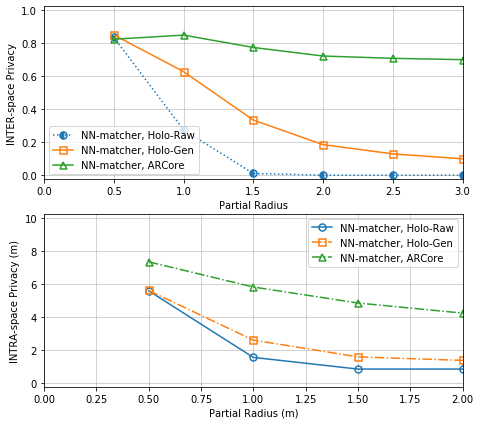

In [17]:
fig=plt.figure(figsize=(7.5, 7))

with open(results_path+'/hololens_results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials, raw_errors, ransac_errors = pickle.load(f)
    
with open(results_path+'/arcore_results_partials_nn_matcher.pickle', 'rb') as f:
    arcore_results_partials, arcore_errors = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
ARCoreNN = np.asarray(arcore_results_partials)

ax1 = fig.add_subplot(211) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")

markersize = 7
linewidth = 1.5

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Holo-Raw"
)
ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Holo-Gen"
)
ax1.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,1],
    "-^",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)

ax1.legend(loc = "lower left", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

ax2 = fig.add_subplot(212) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,2)

ax2.set_ylabel("INTRA-space Privacy (m)")
ax2.set_xlabel("Partial Radius (m)")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Holo-Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Holo-Gen"
)
ax2.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,2],
    '-.^',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);
#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


In [18]:

with open('testing_results/nn_matcher/hololens_results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials, raw_errors, ransac_errors = pickle.load(f)

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

with open("testing_results/nn_matcher/hololens_partials_summary_results.pickle",'wb') as f:
    pickle.dump([results_partials, per_space_score, perf_scores],f)
    

In [19]:
with open("testing_results/nn_matcher/arcore_results_partials_nn_matcher.pickle", 'rb') as f:
    [arcore_results_partials, arcore_errors] = pickle.load(f)
    
arcore_nn_per_space_score = []
arcore_nn_perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in arcore_errors:
    
    partial_errors = np.asarray(partial_errors[:,[0,3]], dtype=int)

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[1])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,1])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average=None)

    arcore_nn_per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,1],average=None),
        prec_score,
        recl_score
    ])

    arcore_nn_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    
arcore_nn_per_space_score = np.asarray(arcore_nn_per_space_score)
arcore_nn_perf_scores = np.asarray(arcore_nn_perf_scores)

with open("testing_results/nn_matcher/arcore_partials_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores],f)
    

# Scratch

In [ ]:
# Hololens data

results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 5.1, 0.25):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'wb') as f:
    pickle.dump([results_partials, raw_errors, ransac_errors],f)


In [ ]:
# Results for ARCore dataset

arcore_results_partials = []

#raw_errors = []    
arcore_ransac_errors = []

with open('../../spatial-privacy/descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)

for radius in np.arange(0.25, 3.1, 0.25):

    try:
        with bz2.BZ2File("testing_results/nn_matcher_arcore/{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting arcore scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, arcore_descriptors[:-1])
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_results_partials.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    arcore_ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open("testing_results/nn_matcher_arcore/results_partials_nn_matcher.pickle", 'wb') as f:
    pickle.dump([arcore_results_partials, arcore_ransac_errors],f)